# Comparing Cross Entropy and Mean Squared Error for Classification Loss

The [Machine Learning course on Coursera by Andrew Ng](https://www.coursera.org/learn/machine-learning), discusses the need for convex loss function for fitting the parameters of the model or hypothesis function $y = h_\theta(x)$.

For binary classification the hypothesis function is the sigmoid function $\sigma (z) = 1/(1+e^{-z})$. 

Finding the global minimum of a convex function is certainly the better than non-convex function that have global minimum in addition to several local minima. In this course, Andrew Ng mentions that because the hypothesis function is non-linear,  the mean squared error 
$$ \frac{1}{2m} \sum_{i = 1}^{m} \left(h_\theta(x^{(i)}) - y^{(i)} \right)^2 $$
is a non-convex function that has many local minima. He then provides an alternative loss/cost function:

$$ C(\theta) = \left\{
\begin{array} \\ 
  \begin{align*}  & -\log(h_\theta(x))  \,\,\,  & \text{if} \,\, y=1 \\ 
                               & -\log(1-h_\theta(x)) \,\,\,  & \text{if} \,\, y=0 
                        \end{align*} 
\end{array} \right.
$$
and very nicely shows that its convex over its permissible values. 

The cost function can be rewritten in one line as follows: 

$$ C(\theta) = - y  \log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))$$ where $y$ takes only 0 or 1 as values.

The cross entropy loss function over all examples then is given by:
$$ \frac{1}{m} \sum_{i = 1}^{m} \left(  - y^{(i)}  \log(h_\theta(x^{(i)})) - (1-y^{(i)})\log(1-h_\theta(x^{(i)})) \right)$$

The cross entropy happens to be the log likelihood of the binomial distribution of this binary classification problem. 

The goal of this note is to look at an example comparing the performance of the model using both loss functions and visualizing them in the parameter space $(\theta_0, \theta_1)$

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn import datasets
from scipy import optimize
import matplotlib.pyplot as plt

import utils
from utils import *

from sklearn.model_selection import train_test_split

%matplotlib inline

In [250]:
import warnings
warnings.filterwarnings("ignore")

In [276]:
import importlib
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\Hala\\Documents\\DeepLearning\\Nahil_Sobh\\ML_training_git\\CE_MSE_comparison\\utils.py'>

### Create the dataset 

We create the dataset that we are working with using scikit-learn tool. 
For visualzation purposes we want only one feature. 

In [2]:
X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=1,
                   random_state=0)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4, random_state = 1235)


(1000, 1)


Let's visualize the training and test data

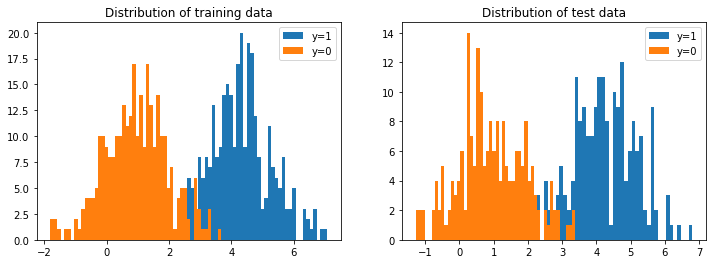

In [3]:

plt.subplots(1,2, figsize = (12,4))
plt.subplot(121)
plt.hist(X_train[y_train==1], bins = 50)
plt.hist(X_train[y_train==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of training data')

plt.subplot(122)
plt.hist(X_test[y_test==1], bins = 50)
plt.hist(X_test[y_test==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of test data')
plt.show()

The hypothesis function has the form:
$$ h_\theta(x) = \frac{1}{1+\exp(-(\theta_0 + \theta_1 x))}$$

to account for the intercept term in $\theta_0 + \theta_1 x$ we add a column of ones to the data matrix X

In [4]:
X_train_o = np.hstack((np.ones((X_train.shape[0],1)),X_train))
X_test_o = np.hstack((np.ones((X_test.shape[0],1)),X_test))

We define below the cross entropy cost function and mean square error cost function. 

For visualization of the cross entropy I needed to modify the sigmoid function. The logarithm of sigmoid when its value is 0.0 or the logarithm of 1-sigmoid when the sigmoid value is 1.0, becomes `-inf`. To avoid these cases. I carry the following modifications:



$$ \text{sigmoid}_{\text{modified}}(z) = \left\{
\begin{array} \\
  \begin{align*}  & \text{sigmoid}(z)-10^{-10}  \,\,\,  & \text{if} \,\, \text{sigmoid}(z) > 0.999 \\ 
                  & \text{sigmoid}(z) \,\,\,  & \text{if} \,\,\,\, 0.001 \le \text{sigmoid}(z) \le 0.999 \\
                  & \text{sigmoid}(z) + 10^{-10} \,\,\,  & \text{if} \,\, \text{sigmoid}(z) > 0.001
                        \end{align*} 
\end{array} \right.
$$

where $$\text{sigmoid}(z) = \frac{1}{1+\exp(-z)}$$

In [5]:

def costFunction(theta, X, y):
    '''
    We define here the cross entropy loss function
    takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(y)  
    
    #initialize loss J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    z = np.matmul(theta,X.T)
    pred = sigmoid(z)
    
    # for visualization purposes we do not want the pred
    # to take 1 or 0 values so that the log(pre) and 
    # log(1-pred) do not taake -inf values. 
    pred[pred > 0.999] = pred[pred>0.999] - 1e-10
    pred[pred < 0.001] = pred[pred<0.001] + 1e-10
    
    # cross entropy loss
    J = (-1/m)*((np.dot(y,np.log(pred)))+ np.dot(1-y,np.log(1-pred))) 
    
    # the gradient of the J with respect to theta
    grad = (1/m) * np.matmul((pred-y).T,X)
    
    
    return J, grad


def costFunction_MSE(theta, X,y):
    '''
    We define here the mean squared error loss function.
    it takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(y)
    
    #initialize J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    
    z = np.matmul(theta,X.T)
    pred = sigmoid(z)
    
    J = (1/(2*m))* np.dot(y-pred, y-pred)
    
    # gradient of J with respect to theta has extra
    # step of computing h'
    hp = sigmoid_grad(z)
    grad = (-1/m) * np.matmul((hp*(y-pred)).T,X)
    
    return J, grad


### Optimization (minimization) Algorithm(s): 

To find or learn theta that best fits the data, we minimize the loss function using two algorithms. The gradient descent and the truncated Newton method. 
Below we define the gradient descent algorithm.

In [6]:
def gradientDescent(X, y, theta, alpha, num_iter):
    '''
    The algorithm takes X, y and theta as well as
    alpha (the learning rate or step size) and the 
    number of iterations
    It returns the optimal theta that minimizes the loss
    function as well as a record of loss values and thetas
    per iteration. 
    '''
    m = len(y)
    J_history = np.zeros(num_iter)
    theta_hist = []
    for itern in range(num_iter):
        J,grad = costFunction(theta, X,y)
        theta = theta - alpha*grad
        J_history[itern] = J
        theta_hist.append(theta)
        
    return theta, J_history, theta_hist

def gradientDescent_MSE(X, y, theta, alpha, num_iter):
    '''
    The algorithm takes X, y and theta as well as
    alpha (the learning rate or step size) and the 
    number of iterations
    It returns the optimal theta that minimizes the loss
    function as well as a record of loss values and thetas
    per iteration. 
    '''
    m = len(y)
    J_history = np.zeros(num_iter)
    theta_hist = []
    for itern in range(num_iter):
        J,grad = costFunction_MSE(theta, X,y)
        theta = theta - alpha*grad
        J_history[itern] = J
        theta_hist.append(theta)
        
    return theta, J_history, theta_hist

Now we run the **gradient descent algorithm** for both loss function and print out the optimal theta

In [117]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
theta_ce, J_hist_ce, theta_hist_ce = gradientDescent(X_train_o,y_train,theta_0, 0.1, 40000)
theta_ce_lr1, J_hist_ce_lr1, theta_hist_ce_lr1 = gradientDescent(X_train_o,y_train,theta_0, 1.0, 40000)

In [118]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
theta_mse, J_hist_mse, theta_hist_mse = gradientDescent_MSE(X_train_o,y_train,theta_0, 0.1, 60000)
theta_mse_lr1, J_hist_mse_lr1, theta_hist_mse_lr1 = gradientDescent_MSE(X_train_o,y_train,theta_0, 1, 60000)

In [119]:
print('theta using cross entropy (lr = 0.1): ',theta_ce)
print('theta using cross entropy (lr = 1.0): ',theta_ce_lr1)
print('theta using MSE (lr = 0.1): ', theta_mse)
print('theta using MSE (lr= 1.0): ', theta_mse_lr1)

theta using cross entropy (lr = 0.1):  [-9.45304597  3.54313504]
theta using cross entropy (lr = 1.0):  [-9.46900887  3.54876697]
theta using MSE (lr = 0.1):  [-7.35907907  2.7801958 ]
theta using MSE (lr= 1.0):  [-8.67166599  3.25799991]


First we check plots of the loss function. I have run the MSE loss function using the same learning rate 0.1 but it did not converge fast enough to the best value. So I tried learning rate of 1.0 and found it converged faster, as the plot shows.

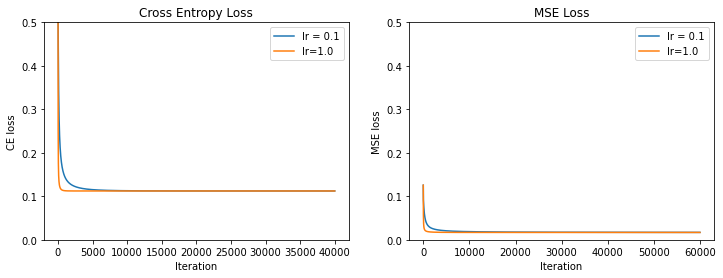

In [120]:
plt.subplots(1,2,figsize= (12,4))
plt.subplot(121)
plt.plot(J_hist_ce)
plt.plot(J_hist_ce_lr1)
plt.ylim((0,0.5))
plt.legend(['lr = 0.1', 'lr=1.0'])
plt.title('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.ylabel('CE loss')

plt.subplot(122)
plt.plot(J_hist_mse)
plt.plot(J_hist_mse_lr1)
plt.ylim((0,0.5))
plt.legend(['lr = 0.1', 'lr=1.0'])
plt.title('MSE Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE loss')
plt.show()

**For visualization** we choose a few values of thetas leading to the minimum. 

In [121]:
th_ce_short_list = [theta_hist_ce_lr1[i] for i in range(0,1000,200)]
[th_ce_short_list.append(theta_hist_ce_lr1[i]) for i in range(1000,40000,4000)]

ths1 = []
ths2 = []
for i in range(len(th_ce_short_list)):
    ths1.append(th_ce_short_list[i][0])
    ths2.append(th_ce_short_list[i][1])

In [122]:
th_mse_short_list = [theta_hist_mse_lr1[i] for i in range(0,8000,1000)]
[th_mse_short_list.append(theta_hist_mse_lr1[i]) for i in range(8000,60000,4000)]

ths11 = []
ths22 = []

for i in range(len(th_mse_short_list)):
    ths11.append(th_mse_short_list[i][0])
    ths22.append(th_mse_short_list[i][1])

Now we run the **truncated Newton method** which is faster and more efficient.

In [13]:
# optimization code is copied from https://github.com/dibgerge/ml-coursera-python-assignments/exercise2


epsilon = 4
np.random.seed(32435)
initial_theta = np.random.uniform(-epsilon, epsilon, 2)

# set options for optimize.minimize
options= {'maxiter': 10000}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res_ce = optimize.minimize(costFunction,
                        initial_theta,
                        (X_train_o, y_train),
                        jac=True,
                        method='TNC',
                        options=options)

res_mse = optimize.minimize(costFunction_MSE,
                        initial_theta,
                        (X_train_o, y_train),
                        jac=True,
                        method='TNC',
                        options=options)


# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost_ce2 = res_ce.fun

# the optimized theta is in the x property
theta_ce2 = res_ce.x

cost_mse2 = res_mse.fun
theta_mse2 = res_mse.x

Here are the results

In [14]:
print('Minimization using truncated Newton method')

print('\n Results using Cross Entropy loss')
print('\n \t theta ', theta_ce2)
print(' \t cost ', cost_ce2)
print('\t decision boundary : y = 1 if  x >= % 2.3f' %(-theta_ce2[0]/theta_ce2[1]))

print('\n Results using MSE loss')
print('\n \t theta ', theta_mse2)
print(' \t cost ', cost_mse2)
print('\t decision boundary : y = 1 if x >= % 2.3f' %(-theta_mse2[0]/theta_mse2[1]))


Minimization using truncated Newton method

 Results using Cross Entropy loss

 	 theta  [-9.46810766  3.54844152]
 	 cost  0.1122807275105055
	 decision boundary : y = 1 if  x >=  2.668

 Results using MSE loss

 	 theta  [-8.67102089  3.25777273]
 	 cost  0.01692208352634124
	 decision boundary : y = 1 if x >=  2.662


## Classification Results
From the values of the decision boundary, we see that the results using the two methods would be very similar. But lets compute the exact values of standard classification metrics.

First we look at the cross entropy loss results

In [39]:
results(X_test_o,y_test,theta_ce)

False negatives  14
false positive  12
true negatives  190
true positives  184
total true values  374


precision 0.9388
recall 0.9293
accuracy  0.9350 
F1 score  0.9340 


All metrics look very good, almost perfect. 

Now we look at the MSE loss results, we expect them to be not far from the above.

In [40]:
results(X_test_o,y_test,theta_mse)

False negatives  14
false positive  13
true negatives  189
true positives  184
total true values  373


precision 0.9340
recall 0.9293
accuracy  0.9325 
F1 score  0.9316 


# Visualizatioin Of Loss Funtions

Now its time to turn our attention to the loss functions. We have an idea that the MSE loss function has a local minimum in addition to the global minimum. I will focus on the global minimum in the first set of visualizations. 

Later in the notebook, I will be looking at local minima.


We will look at slices in near the optimal $\theta$. One slice in $\theta_0$ direction and another in $\theta_1$ direction. We will also plot the loss functions in three dimensions. We want to check convexity property. If not convex are there other local minima. 
We start with the cross entropy loss function. 


## Profile Visualization Of Cross Entropy Loss

First we look at profile (slice) along each axis. Next we plot contour and surface in 3d.

I emphasize here that these plots are of the modified sigmoid whose image lies not between 0 and 1 but rather between 1 - 1e-10 and 0 + 1e-10. I did this to extend the domain of permissible values of the cross entropy loss function.

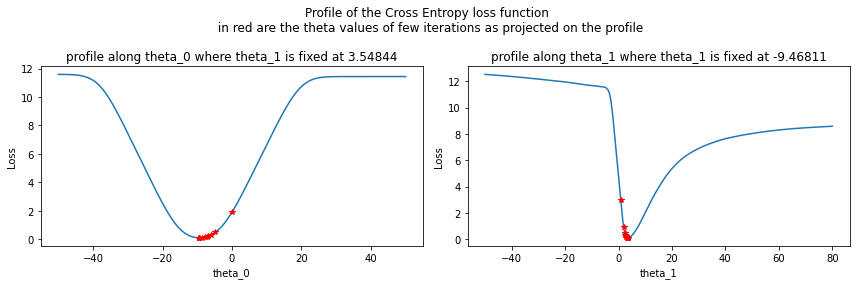

In [108]:
# Preparing data range for profile plots        
th1_1 = np.arange(-50,50,0.01)
th2_1 = theta_ce2[1]

J_t1, J_tt1 = utils.get_profile(costFunction, X_train_o, y_train, th1_1, th2_1, ths1, ths2, 'theta_0') 

th1_2 = theta_ce2[0]
th2_2 = np.arange(-50,80,0.01)

J_t2, J_tt2 = utils.get_profile(costFunction, X_train_o, y_train, th1_2, th2_2, ths1, ths2, 'theta_1') 

utils.plot_profiles(th1_1, th2_2, ths1, ths2, J_t1, J_tt1, J_t2, J_tt2, th2_1, th1_2, 'Cross Entropy')

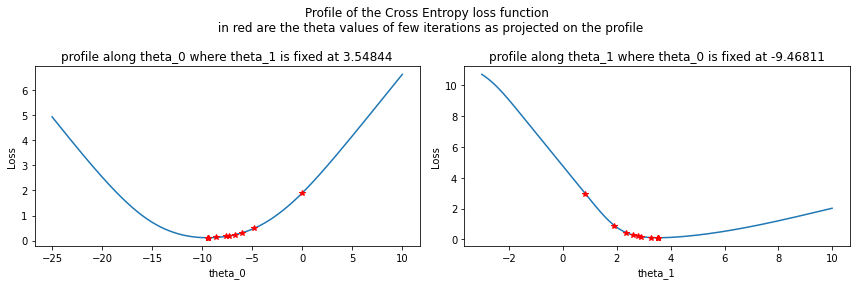

In [111]:
# Preparing data range for profile plots        
th1_1 = np.arange(-25,10,0.01)
th2_1 = theta_ce2[1]

J_t1, J_tt1 = utils.get_profile(costFunction, X_train_o, y_train, th1_1, th2_1, ths1, ths2, 'theta_0') 

th1_2 = theta_ce2[0]
th2_2 = np.arange(-3,10,0.01)

J_t2, J_tt2 = utils.get_profile(costFunction, X_train_o, y_train, th1_2, th2_2, ths1, ths2, 'theta_1') 

utils.plot_profiles(th1_1, th2_2, ths1, ths2, J_t1, J_tt1, J_t2, J_tt2, th2_1, th1_2,'Cross Entropy')

# Profile Visualization of MSE Loss

Here we compare the above with MSE loss profiles. We consider the Zoomed out view first and then an Zoomed in view. 

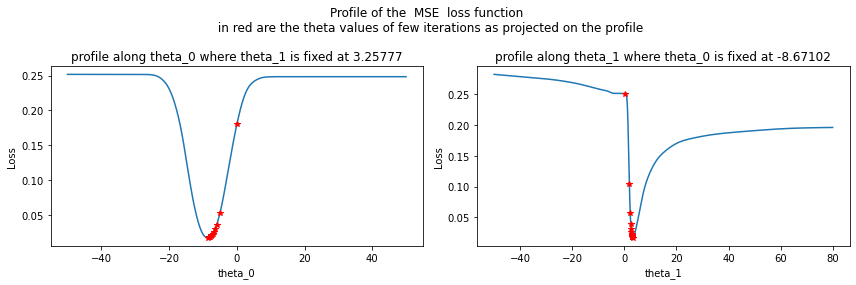

In [113]:
th1_m1 = np.arange(-50,50,0.01)
th2_m1 = theta_mse2[1]

K_t1, K_tt1 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m1, th2_m1, ths11, ths22, 'theta_0') 

th1_m2 = theta_mse2[0]
th2_m2 = np.arange(-50,80,0.01)

K_t2, K_tt2 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m2, th2_m2, ths11, ths22, 'theta_1')

utils.plot_profiles(th1_m1, th2_m2, ths11,ths22, K_t1, K_tt1, K_t2, K_tt2, th2_m1, th1_m2, ' MSE ')

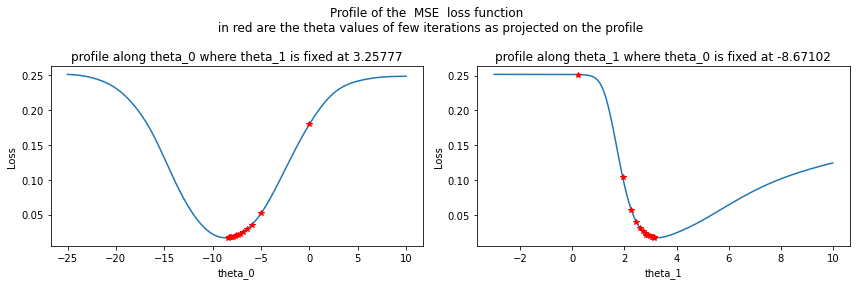

In [114]:
th1_m1 = np.arange(-25,10,0.01)
th2_m1 = theta_mse2[1]

K_t1, K_tt1 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m1, th2_m1, ths11, ths22, 'theta_0') 

th1_m2 = theta_mse2[0]
th2_m2 = np.arange(-3,10,0.01)

K_t2, K_tt2 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m2, th2_m2, ths11, ths22, 'theta_1')

utils.plot_profiles(th1_m1, th2_m2, ths11,ths22, K_t1, K_tt1, K_t2, K_tt2, th2_m1, th1_m2,' MSE ')

# 3D **Visualizations** of Loss Functions

Three dimensional view of the surface allow us to see the globale minima, convexity proporty if any. 

The contour view aids in understanding the surface where its is not so clear. 

## Cross Entropy Loss: surface and contour
 

In [76]:
# good view using x1: [-12,6], x2: [-6, 12]
x1 = np.sort(np.concatenate((np.linspace(-20,0,401),np.array(ths1))))
x2 = np.sort(np.concatenate((np.linspace(-1,6,401),np.array(ths2))))
x12, x21 = np.meshgrid(x1, x2)


J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, X_train_o, y_train)

In [77]:
Js12 = np.zeros(len(ths1))
for i in range(len(ths1)):
    theta = np.array([ths1[i], ths2[i]])
    Js12[i], _ = costFunction(theta, X_train_o,y_train)

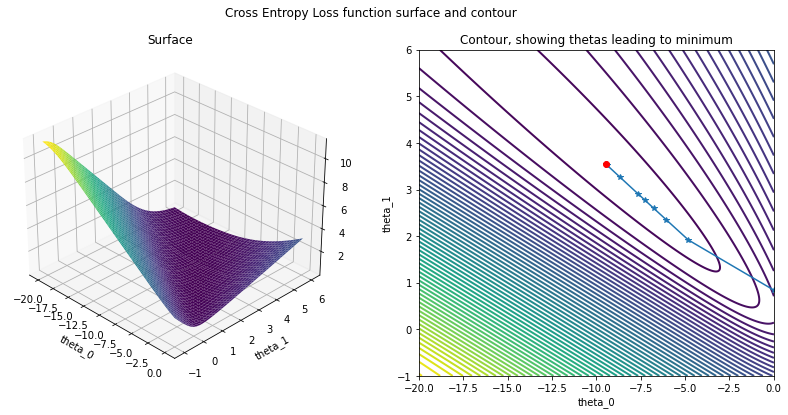

In [79]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,-45)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [84]:
# good view using x1: [-12,6], x2: [-6, 12]
x1 = np.sort(np.concatenate((np.linspace(-80,80,801),np.array(ths1))))
x2 = np.sort(np.concatenate((np.linspace(-80,80,801),np.array(ths2))))
x12, x21 = np.meshgrid(x1, x2)

J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, X_train_o, y_train)

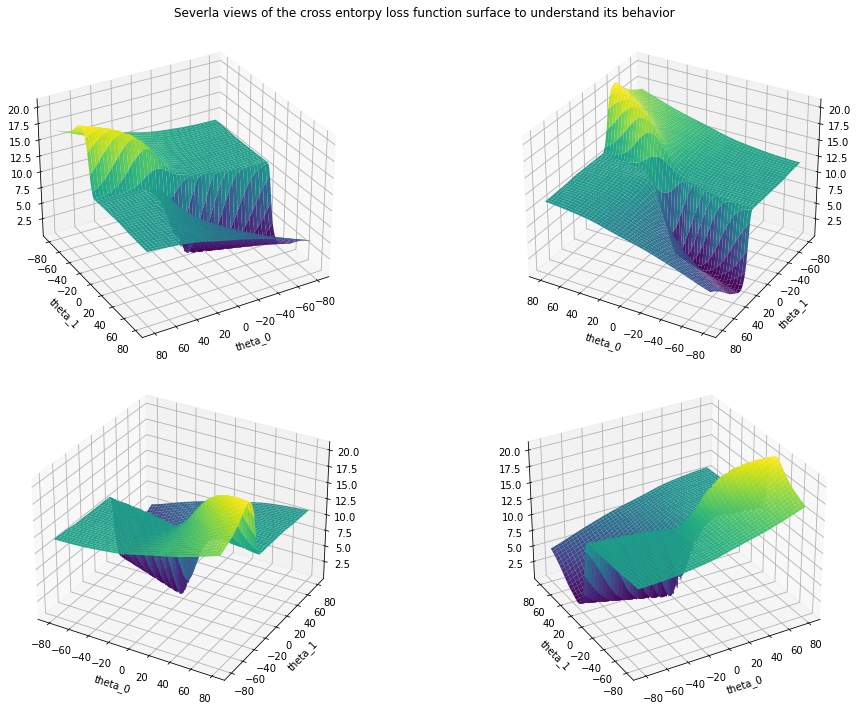

In [94]:
fig = plt.figure(figsize = (16,10))

# Plot the surface.
ax = fig.add_subplot(221, projection='3d')
# Plot the surface.
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30, 60)
#ax.plot(ths1, ths2,Js12.T,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')

ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,120)
#ax.plot(ths1, ths2, Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')

ax = fig.add_subplot(223, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,300)
#ax.plot(ths1, ths2,Js12.T,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')

ax = fig.add_subplot(224, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,240)
#ax.plot(ths1, ths2, Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')


plt.suptitle('Severla views of the cross entorpy loss function surface to understand its behavior')
plt.tight_layout()
plt.show()

## MSE Loss Function: surface and contour

In [26]:
tt1z = np.sort(np.concatenate((np.linspace(-20,0,401),np.array(ths11))))
tt2z = np.sort(np.concatenate((np.linspace(-1,6,401),np.array(ths22))))

tt12z, tt21z = np.meshgrid(tt1z, tt2z)

K12z = np.zeros((tt12z.shape[0],tt21z.shape[0]))
for i in range(tt12z.shape[0]):
    for j in range(tt21z.shape[0]):
        theta = np.array([tt12z[i,j], tt21z[i,j]])
        K12z[i,j],_= costFunction_MSE(theta, X_train_o, y_train)

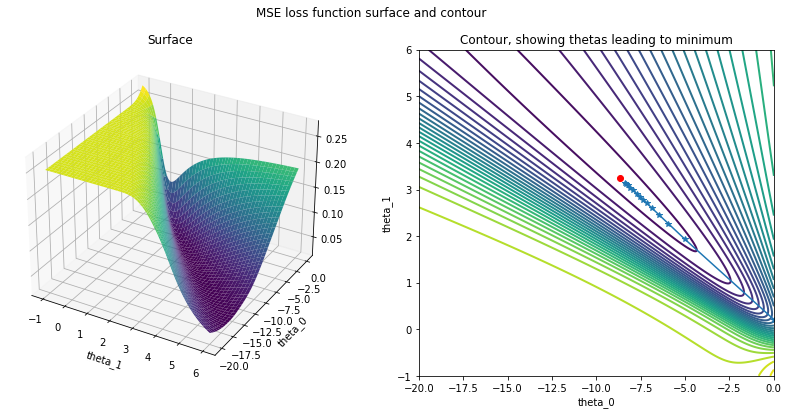

In [81]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(tt21z, tt12z, K12z, cmap='viridis', linewidth=0.2)
plt.xlabel('theta_1')
plt.ylabel('theta_0')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(tt1z, tt2z, K12z, linewidths=2, cmap='viridis', levels = 30)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')
plt.suptitle('MSE loss function surface and contour')
plt.show()


We look at a zoom out over view of the surface below

In [28]:
tt1 = np.sort(np.concatenate((np.linspace(-80,80,801),np.array(ths11))))
tt2 = np.sort(np.concatenate((np.linspace(-80,80,801),np.array(ths22))))

tt12, tt21 = np.meshgrid(tt1, tt2)

K12 = np.zeros((tt12.shape[0],tt21.shape[0]))
for i in range(tt12.shape[0]):
    for j in range(tt21.shape[0]):
        theta = np.array([tt12[i,j], tt21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, X_train_o, y_train)

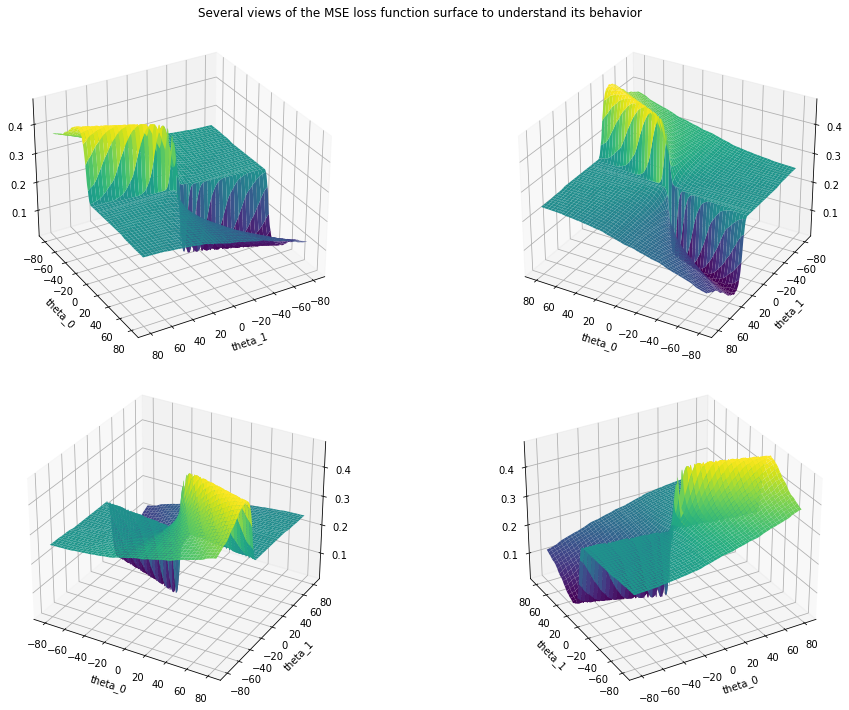

In [96]:

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(221, projection='3d')
# Plot the surface.
ax.plot_surface(tt12, tt21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,60)
plt.xlabel('theta_1')
plt.ylabel('theta_0')


ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(tt12, tt21,K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,120)
plt.xlabel('theta_0')
plt.ylabel('theta_1')

ax = fig.add_subplot(223, projection='3d')
ax.plot_surface(tt12, tt21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,300)
plt.xlabel('theta_0')
plt.ylabel('theta_1')

ax = fig.add_subplot(224, projection='3d')
ax.plot_surface(tt12, tt21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,240)
plt.xlabel('theta_0')
plt.ylabel('theta_1')


plt.suptitle('Several views of the MSE loss function surface to understand its behavior')
plt.tight_layout()
plt.show()

Similar to the impression we get from the profiles, the surfaces of the cross entropy loss as well as the MSE loss are strikingly very similar. However, the MSE surface has sharp turns, more tight and less smooth than the cross entropy surface. 

The above graphs show the functions are none convex away from the global minimum. The cross entropy surface has wider range of values, a wider basin of attraction, where it is convex compared to the MSE loss function. 

Looking back at the gradient of each of the loss functions, we find this plausible. Recall:

$$\nabla J_{\text{Cross Entropy}}(\theta) = \frac{1}{m} \left(h(X^{T}\theta) - y\right)^{T} X $$

while gradient of the MSE loss:

$$ \nabla J_{\text{MSE}}(\theta) = \frac{1}{m} h'(X^{T}\theta) \left(h(X^{T}\theta) - y\right)^{T} X $$

where $h(z) = 1/(1+e^{-z})$ is the sigmoid function whose derivative is $h'(z) = h(z)(1-h(z))$. Both the sigmoid and its gradient are positive and less than one. 

Since, the gradient are similar except that MSE gradient is multiplied by the derivative of the sigmoid. As a result, it accentuate the certain vallies, tops and turns. 

 

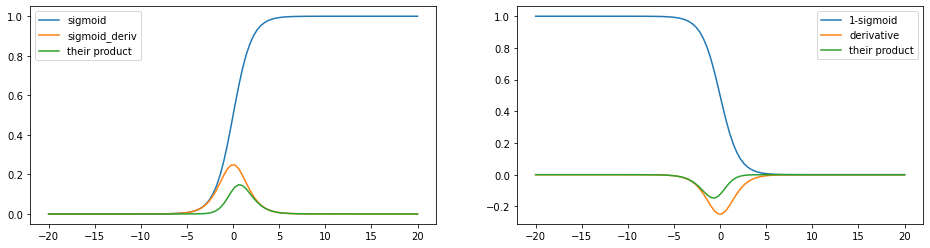

In [152]:
z = np.linspace(-20,20,100)
plt.subplots(1,2, figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(z,sigmoid(z))
plt.plot(z,sigmoid_grad(z))
plt.plot(z,sigmoid_grad(z)*sigmoid(z))
plt.legend(['sigmoid','sigmoid_deriv','their product'])

plt.subplot(1,2,2)
plt.plot(z,1-sigmoid(z))
plt.plot(z,-sigmoid_grad(z))
plt.plot(z,-sigmoid_grad(z)*(1-sigmoid(z)))
plt.legend(['1-sigmoid','derivative','their product'])

plt.show()

# Assessment of MSE loss function when initial values are far away from the origin

One question that I wish to answer is, are there "hidden" local minima of the MSE loss that the graphs do not show? To answer this question, I will consider other values of $\theta$ to start the optimization algorithm that are away from zero. 

Based on the graph of the MSE loss function one is curious whether the minimizing algorithms will still converge to the same value or get stuck in other local minima. These local minima are not very clear from the surface plot. One can only vagely realize them near the upper ridge on the graph. 

Here, we show investigations of some results that shed light on the location of local minima. 

We look over two sets, one with set of initial values grids. We display them below. Moreover, we will look at the contour plots of select local minima along with path using gradient descent.

## Set 1
### Data generation

In [253]:
from itertools import product 

#Set 1: grid of initial values 
init_t0_pts = np.arange(5,10,0.5)
init_t1_pts = np.arange(-3,0,0.5)
iv=[]
for v in zip(list(product(init_t0_pts, init_t1_pts))):
    iv.append(v[0])
init_theta = np.array(iv)

#Define dataframe to store results
results_lcm = pd.DataFrame(columns=['init_theta_0', 'init_theta_1','optm_theta_0', 'optm_theta_1', 'loss'])

# set options for optimize.minimize
options= {'maxiter': 40000}
for i, theta_0 in enumerate(init_theta):
    res_mse_2 = optimize.minimize(costFunction_MSE,
                            theta_0,
                            (X_train_o, y_train),
                            jac=True,
                            method='CG',
                            options=options)
    results_lcm.loc[i,'init_theta_0']=init_theta[i,0]
    results_lcm.loc[i,'init_theta_1']=init_theta[i,1]
    results_lcm.loc[i,'optm_theta_0']=res_mse_2.x[0]
    results_lcm.loc[i,'optm_theta_1']=res_mse_2.x[1]
    results_lcm.loc[i,'loss']=res_mse_2.fun

From the above analysis we know the global minimum value of the MSE loss function is 0.016922. 

Lets see if the minimizer detected local minima with larger loss values. 

In [241]:
results_lcm.loc[(results_lcm['loss']>0.017),:]

init_theta_0 init_theta_1 optm_theta_0 optm_theta_1       loss
0             5           -3     -8.97014     -2.77744   0.251668
1             5         -2.5     -9.08071     -2.36437   0.251667
6           5.5           -3     -14.7186     -5.10411   0.251667
7           5.5         -2.5     -8.45671      -1.3999   0.251666
12            6           -3     -14.4038     -3.53009   0.251667
18          6.5           -3      -24.416      -6.4124   0.251667
22          6.5           -1     -91.0443      36.0261  0.0204383
25            7         -2.5     -338.955      141.558  0.0266444
36            8           -3     -139.123      55.1285  0.0205763
48            9           -3     -1651.11      978.682  0.0541669

There are a number of $\theta$ values with loss at 0.25166 not too far from the global minimum. These correspond to the wings on the surface plot.  

On the other hand, there are far $\theta$s with loss too close to the global minimum! these are questionable.  

Lets plot the grid of initial values and displaying the corresponding optimal values with loss at 0.25166. 

In the plots below we draw a circle around the global minimum to distingshit it. 

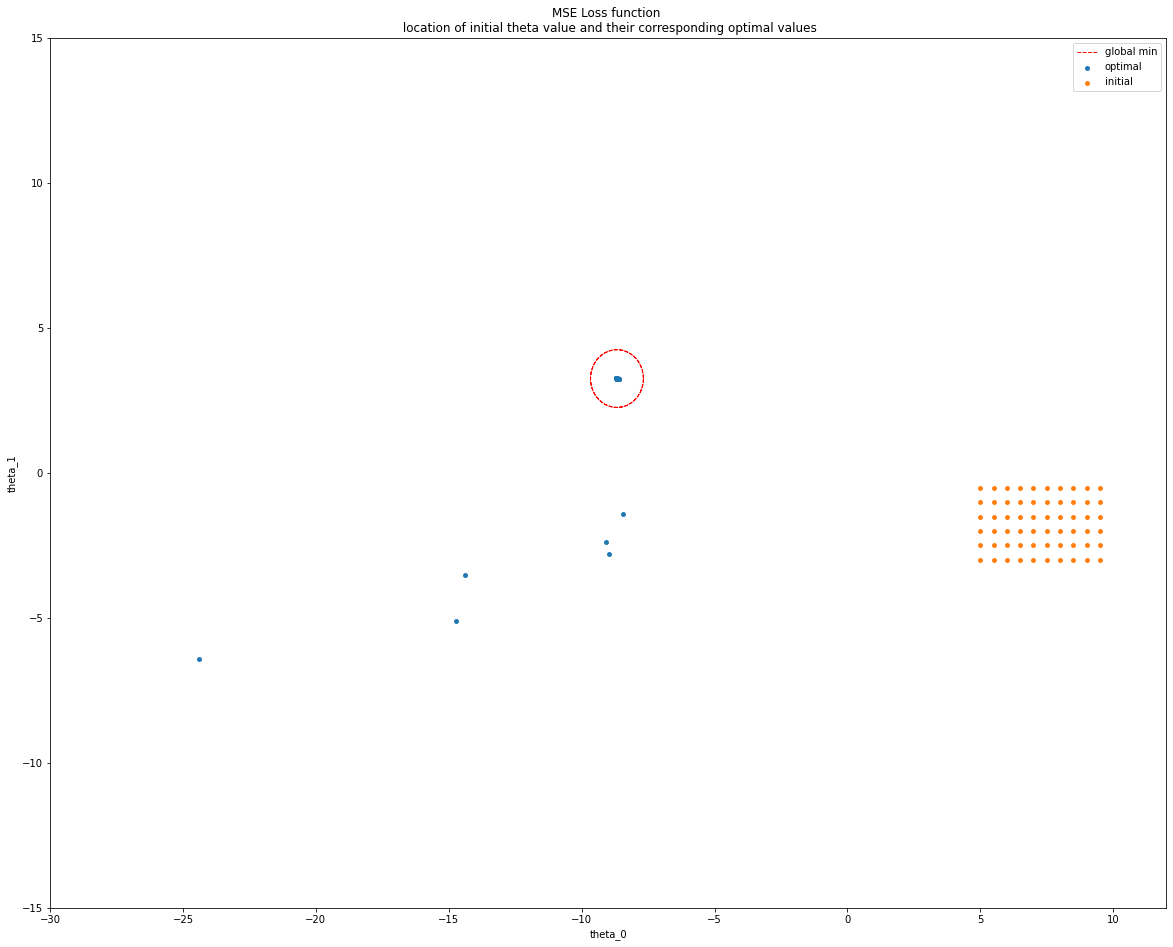

In [194]:
import matplotlib as mpl
#plot circle centerd at global minimum
t = np.linspace(-2*np.pi, 2*np.pi, 50)
center = np.array([-8.67102089, 3.25777273])
circle = np.array([center[0]+np.cos(t), center[1]+np.sin(t)])
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '--'

plt.figure(figsize = (20,16))

plt.scatter(results_lcm['optm_theta_0'],results_lcm['optm_theta_1'], s = 15)
plt.scatter(results_lcm['init_theta_0'], results_lcm['init_theta_1'], s=15)
plt.plot(circle[0],circle[1], c='r')

plt.legend(['global min', 'optimal', 'initial'])
plt.title('MSE Loss function \n location of initial theta value and their corresponding optimal values')
plt.xlabel('theta_0')
plt.ylabel('theta_1')

plt
plt.xlim((-30,12))
plt.ylim((-15,15))
plt.show()

### Set 1: surface and contour plots of select cases

### Example 1

theta_0_lcm  [ 5.  -2.5]
first theta in record should be close to initial theta
first theta for this run  [ 4.99795783 -2.50159617]
optimal theta lr = 0.1 [-5.83510924  2.22994558]
loss lr=0.1  0.01777857240868217
optimal theta lr =1.0  [-8.66959101  3.25724139]
loss lr= 1.0  0.016922084396251723


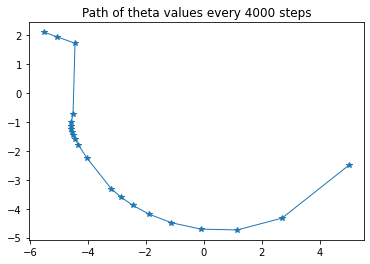

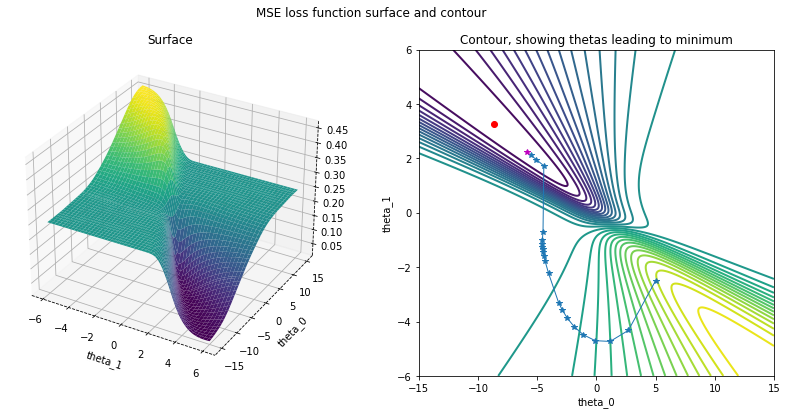

In [239]:
theta_0_lcm = np.array([5.0, -2.5])
iterations = 100000
xmin, xmax = -15, 15
ymin, ymax = -6, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_mse2,'MSE')

### Example 2

theta_0_lcm  [ 9. -3.]
first theta in record should be close to initial theta
first theta for this run  [ 9.0012189  -2.99467987]
optimal theta lr = 0.1 [ 7.06454219 -0.69518332]
loss lr=0.1  0.24745571913848258
optimal theta lr =1.0  [-8.67536555  3.25935234]
loss lr= 1.0  0.016922082329013564


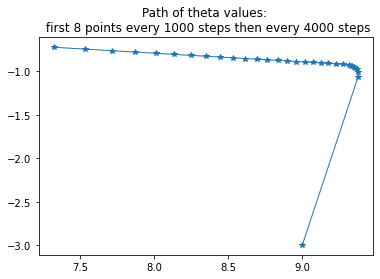

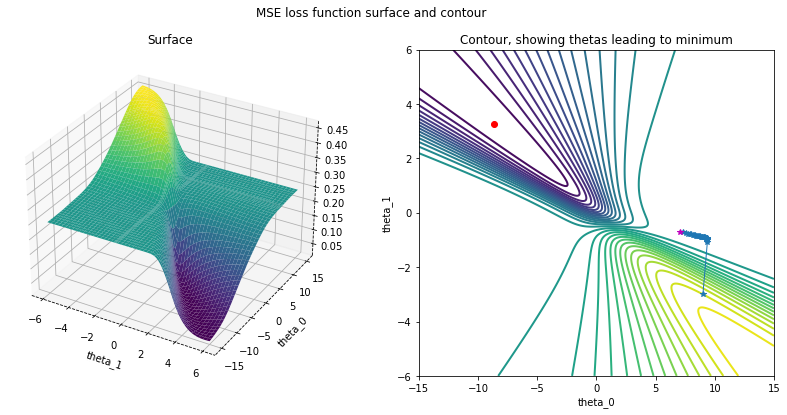

In [243]:
theta_0_lcm = np.array([9.0, -3.0])
iterations = 100000
xmin, xmax = -15, 15
ymin, ymax = -6, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_mse2,'MSE')

## Set 2

In [251]:
from itertools import product 

#Set 2: grid of initial values 
init_t0_pts = np.arange(10,17,0.5)
init_t1_pts = np.arange(-6,3,0.5)
iv=[]
for v in zip(list(product(init_t0_pts, init_t1_pts))):
    iv.append(v[0])
init_theta = np.array(iv)

#Define dataframe to store results
results_lcm2 = pd.DataFrame(columns=['init_theta_0', 'init_theta_1','optm_theta_0', 'optm_theta_1', 'loss'])

# set options for optimize.minimize
options= {'maxiter': 10000}
for i, theta_0 in enumerate(init_theta):
    res_mse_2 = optimize.minimize(costFunction_MSE,
                            theta_0,
                            (X_train_o, y_train),
                            jac=True,
                            method='CG',
                            options=options)
    results_lcm2.loc[i,'init_theta_0']=init_theta[i,0]
    results_lcm2.loc[i,'init_theta_1']=init_theta[i,1]
    results_lcm2.loc[i,'optm_theta_0']=res_mse_2.x[0]
    results_lcm2.loc[i,'optm_theta_1']=res_mse_2.x[1]
    results_lcm2.loc[i,'loss']=res_mse_2.fun

In [220]:
print('total number of cases',results_lcm2.shape[0])
print('cases with loss over 0.2',results_lcm2[results_lcm2['loss']>=0.2].shape)
print('cases with loss over 0.017 ',results_lcm2[results_lcm2['loss']>=0.017].shape) 
print('\n')
np.disp(results_lcm2[results_lcm2['loss']>=0.2].head(10))
print('\n')
print(results_lcm2[results_lcm2['loss']>=0.2].tail(10))

total number of cases 252
cases with loss over 0.2 (205, 5)
cases with loss over 0.017  (220, 5)


   init_theta_0 init_theta_1 optm_theta_0 optm_theta_1      loss
0            10           -6      -32.533     -12.0849  0.251667
1            10         -5.5     -62.8028      1.18781  0.251667
2            10           -5     -21.5614      -10.002  0.251668
3            10         -4.5     -40.0365    -0.607679  0.251667
18         10.5           -6     -22.6536     -10.6013  0.251668
19         10.5         -5.5     -23.0318     -10.6115  0.251667
20         10.5           -5     -37.9092     -11.7127  0.251667
21         10.5         -4.5     -37.6443     -8.08684  0.251667
22         10.5           -4      11.0453     0.154756  0.248326
23         10.5         -3.5      11.3908     0.132982  0.248328


    init_theta_0 init_theta_1 optm_theta_0 optm_theta_1      loss
242         16.5           -2      16.5375     -1.71984  0.248333
243         16.5         -1.5         16.5         -

It is interesting to find some initial values that did not move or moved very little.

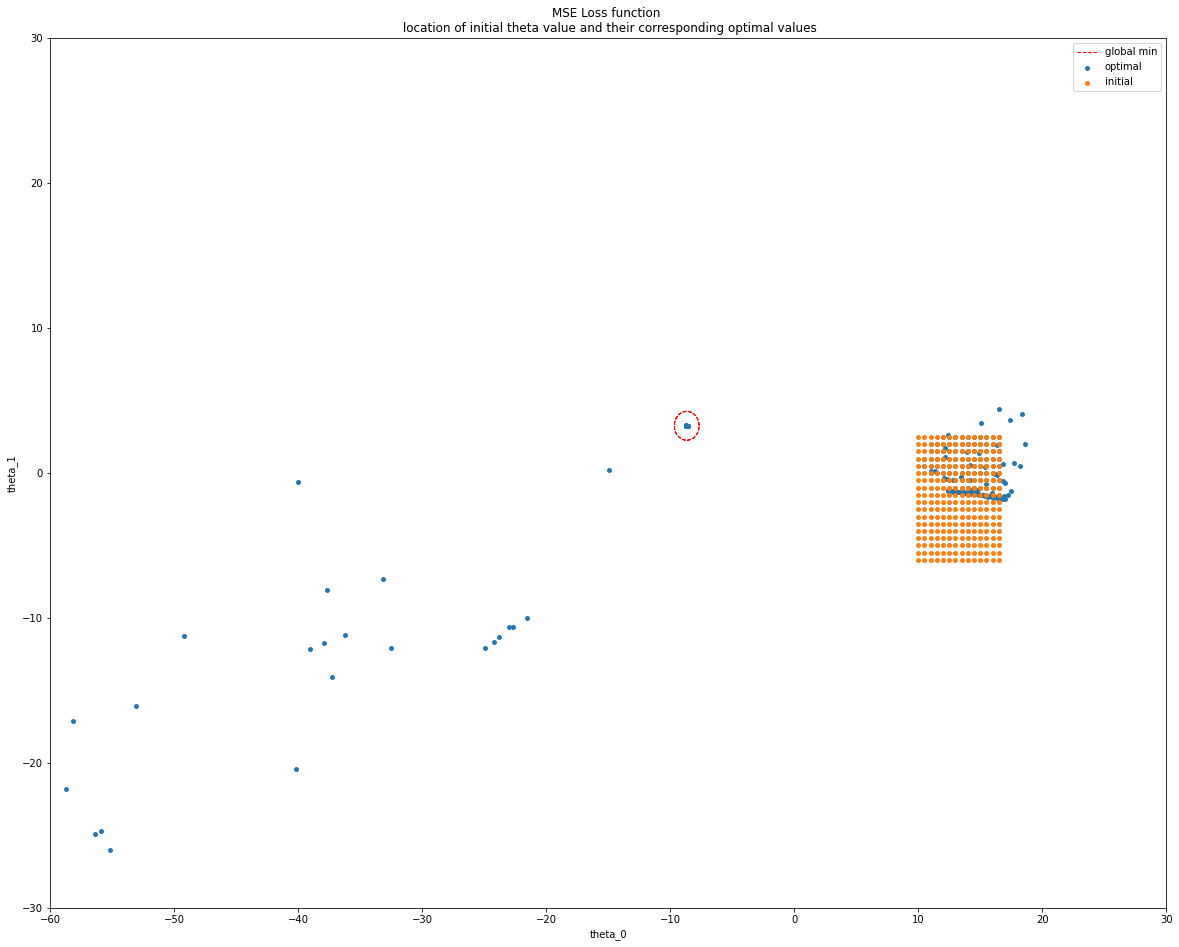

In [213]:
import matplotlib as mpl
#plot circle centerd at global minimum
t = np.linspace(-2*np.pi, 2*np.pi, 50)
center = np.array([-8.67102089, 3.25777273])
circle = np.array([center[0]+np.cos(t), center[1]+np.sin(t)])
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '--'

plt.figure(figsize = (20,16))

plt.scatter(results_lcm2['optm_theta_0'],results_lcm2['optm_theta_1'], s = 15)
plt.scatter(results_lcm2['init_theta_0'], results_lcm2['init_theta_1'], s=15)
plt.plot(circle[0],circle[1], c='r')

plt.legend(['global min', 'optimal', 'initial'])
plt.title('MSE Loss function \n location of initial theta value and their corresponding optimal values')
plt.xlabel('theta_0')
plt.ylabel('theta_1')

plt
plt.xlim((-60,30))
plt.ylim((-30,30))
plt.show()

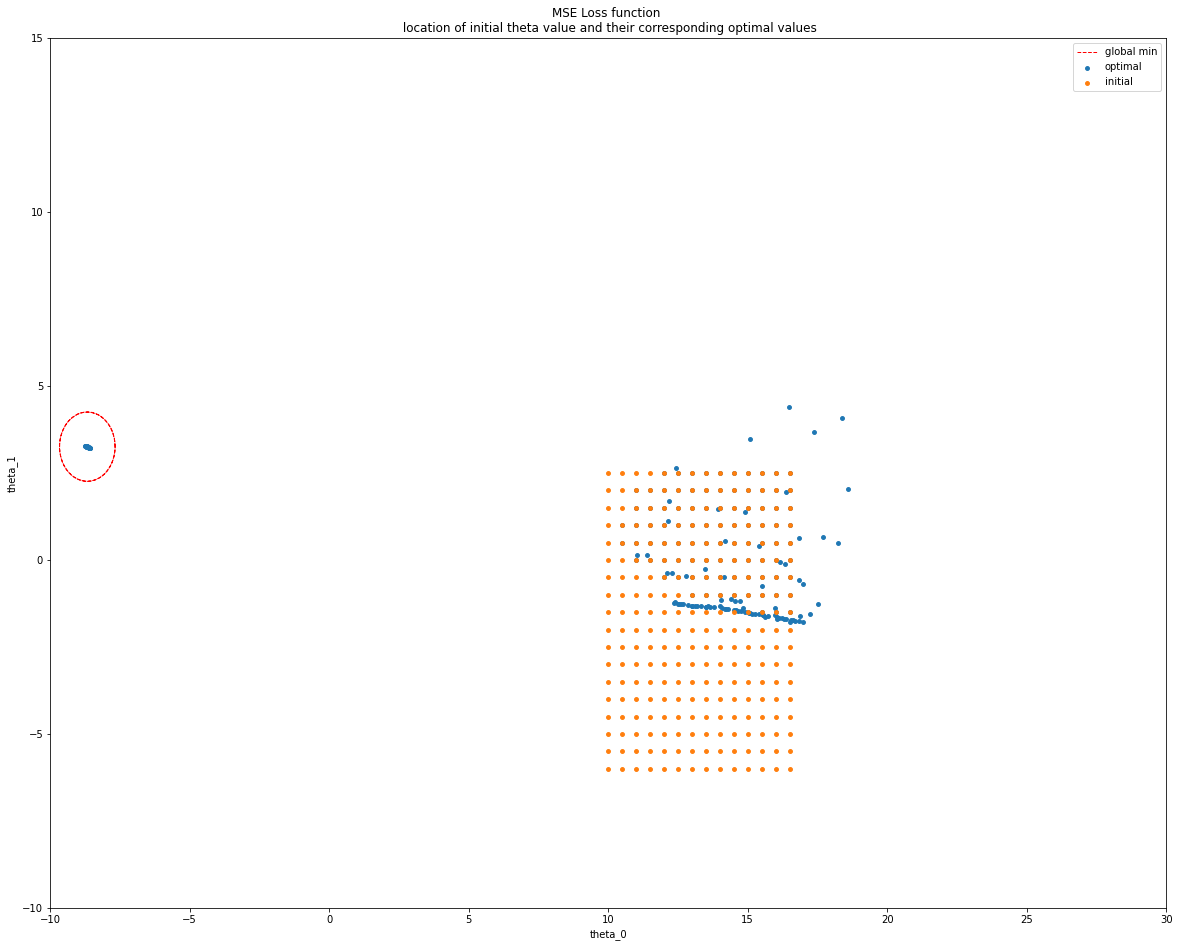

In [215]:
import matplotlib as mpl
#plot circle centerd at global minimum
t = np.linspace(-2*np.pi, 2*np.pi, 50)
center = np.array([-8.67102089, 3.25777273])
circle = np.array([center[0]+np.cos(t), center[1]+np.sin(t)])
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '--'

plt.figure(figsize = (20,16))

plt.scatter(results_lcm2['optm_theta_0'],results_lcm2['optm_theta_1'], s = 15)
plt.scatter(results_lcm2['init_theta_0'], results_lcm2['init_theta_1'], s=15)
plt.plot(circle[0],circle[1], c='r')

plt.legend(['global min', 'optimal', 'initial'])
plt.title('MSE Loss function \n location of initial theta value and their corresponding optimal values')
plt.xlabel('theta_0')
plt.ylabel('theta_1')

plt
plt.xlim((-10,30))
plt.ylim((-10,15))
plt.show()

In [246]:
print(results_lcm2[results_lcm2['optm_theta_1']>=0].head(10))
print(results_lcm2[results_lcm2['optm_theta_1']>=0].tail(10))

   init_theta_0 init_theta_1 optm_theta_0 optm_theta_1       loss
1            10         -5.5     -62.8028      1.18781   0.251667
4            10           -4     -674.444      282.312  0.0266664
5            10         -3.5     -8.74935      3.28643  0.0169224
6            10           -3     -283.147      107.479  0.0211026
7            10         -2.5     -322.261      149.727  0.0291668
8            10           -2     -8.62835      3.24214  0.0169222
9            10         -1.5      -8.6668      3.25641  0.0169221
10           10           -1     -329.636      166.342  0.0358324
11           10         -0.5     -8.67021      3.25731  0.0169221
12           10            0     -8.58136      3.22497  0.0169226
    init_theta_0 init_theta_1 optm_theta_0 optm_theta_1      loss
232           16            2           16            2  0.248333
233           16          2.5           16          2.5  0.248333
234         16.5           -6      18.2454     0.480328  0.248333
235       

### Example 3

theta_0_lcm  [ 8.5 -6.5]
first theta in record should be close to initial theta
first theta for this run  [ 8.49854934 -6.50166924]
optimal theta lr = 0.1 [-8.89611971 -3.56174815]
loss lr=0.1  0.2516812551884949
optimal theta lr =1.0  [-9.29830212 -2.8827814 ]
loss lr= 1.0  0.2516673643551437


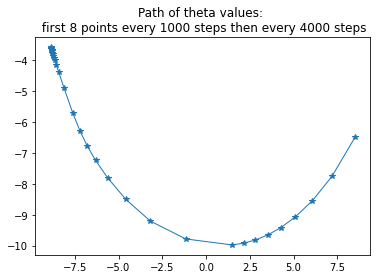

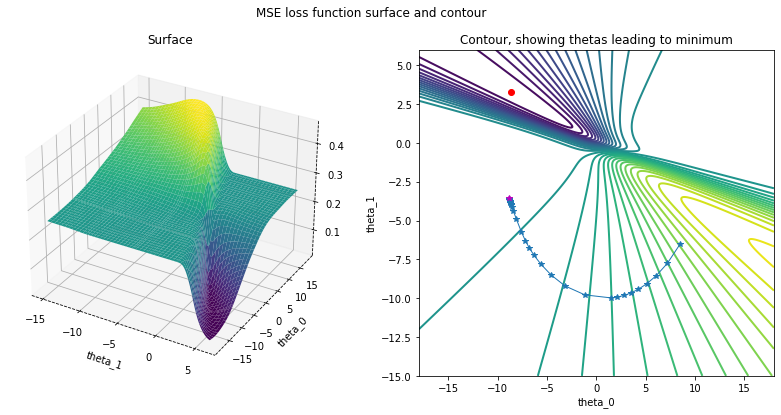

In [248]:
theta_0_lcm = np.array([8.5, -6.5])
iterations = 100000
xmin, xmax = -18, 18
ymin, ymax = -15, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_mse2,'MSE')

### Example 4

theta_0_lcm  [10.5 -5.5]
first theta in record should be close to initial theta
first theta for this run  [10.49873217 -5.50201923]
optimal theta lr = 0.1 [-9.71716709 -4.11054136]
loss lr=0.1  0.25168511987420805
optimal theta lr =1.0  [-10.14836757  -3.37997386]
loss lr= 1.0  0.25166737101823305


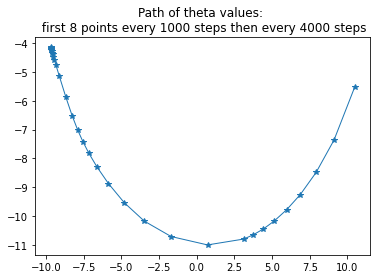

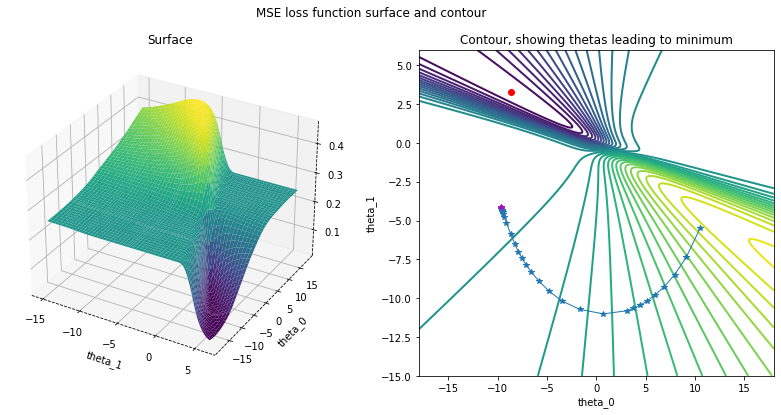

In [247]:
theta_0_lcm = np.array([10.5, -5.5])
iterations = 100000
xmin, xmax = -18, 18
ymin, ymax = -15, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_mse2,'MSE')

### Example 5

theta_0_lcm  [13. -5.]
first theta in record should be close to initial theta
first theta for this run  [13.00009898 -4.99930469]
optimal theta lr = 0.1 [13.72459185 -1.37321728]
loss lr=0.1  0.2483294827139181
optimal theta lr =1.0  [13.42015536 -1.31642532]
loss lr= 1.0  0.2483283552565916


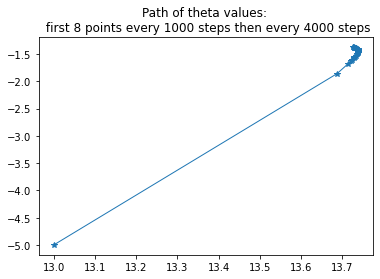

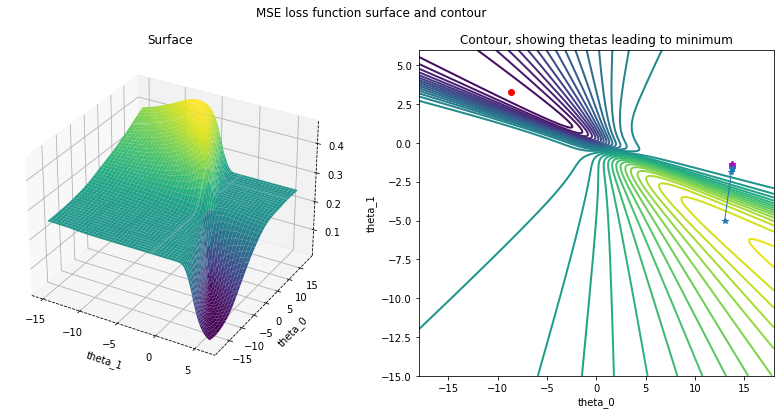

In [252]:
theta_0_lcm = np.array([13.0, -5.0])
iterations = 100000
xmin, xmax = -18, 18
ymin, ymax = -15, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_mse2,'MSE')

## Cross Entropy: local minima?

For fairness we repeat the check the cross entropy loss function to test whether the minimzation algorithm converges to one location, no matter where the initial values are located.

Knowing that the cross entropy surface is more relaxed or stretched out horozontally, we show here some region that lies near one of the wings. In fact, I searched in a reagion similar to the first set of the MSE loss where $-5 \le \theta_0 < 10$ and $-3 \le \theta_1 < 0$ and found all loss values equal to the minimum. 

The set of regions below pick up some values that are above the global minimum.  However, as with the MSE loss cases, we will rerun using gradient descent and with 100000 iterations to check and view the path when the initial $\theta$ lies along on one the wings. 

In [269]:
from itertools import product 

#Set 1: grid of initial values 
init_t0_pts = np.arange(28,40,0.5)
init_t1_pts = np.arange(-6,3,0.5)
iv=[]
for v in zip(list(product(init_t0_pts, init_t1_pts))):
    iv.append(v[0])
init_theta = np.array(iv)

#Define dataframe to store results
results_lcm_ce = pd.DataFrame(columns=['init_theta_0', 'init_theta_1','optm_theta_0', 'optm_theta_1', 'loss'])

# set options for optimize.minimize
options= {'maxiter': 40000}
for i, theta_0 in enumerate(init_theta):
    res_ce_2 = optimize.minimize(costFunction,
                            theta_0,
                            (X_train_o, y_train),
                            jac=True,
                            method='CG',
                            options=options)
    results_lcm_ce.loc[i,'init_theta_0']=init_theta[i,0]
    results_lcm_ce.loc[i,'init_theta_1']=init_theta[i,1]
    results_lcm_ce.loc[i,'optm_theta_0']=res_ce_2.x[0]
    results_lcm_ce.loc[i,'optm_theta_1']=res_ce_2.x[1]
    results_lcm_ce.loc[i,'loss']=res_ce_2.fun

In [273]:
print('total number of cases',results_lcm_ce.shape[0])
print('cases with loss over 0.12 is ',results_lcm_ce[results_lcm_ce['loss']>=0.12].shape[0]) 
#print('\n')
np.disp(results_lcm_ce[results_lcm_ce['loss']>=.12].head())
#print('\n')
#print(results_lcm_ce[results_lcm_ce['loss']>=0.2].tail(10))

total number of cases 432
cases with loss over 0.12 is  209
   init_theta_0 init_theta_1 optm_theta_0 optm_theta_1      loss
2            28           -5       -60.92      22.3196  0.373834
35         28.5          2.5         28.5          2.5   11.4324
53           29          2.5           29          2.5   11.4338
71         29.5          2.5         29.5          2.5   11.4347
89           30          2.5           30          2.5   11.4353


It seems that in this region

theta_0_lcm  [28. -5.]
first theta in record should be close to initial theta
first theta for this run  [27.95575896 -5.01510601]
optimal theta lr = 0.1 [-9.46900016  3.5487639 ]
loss lr=0.1  0.11228072692162921
optimal theta lr =1.0  [-9.46900887  3.54876697]
loss lr= 1.0  0.1122807269215755


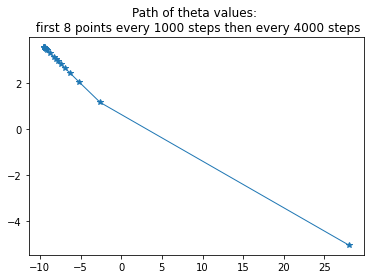

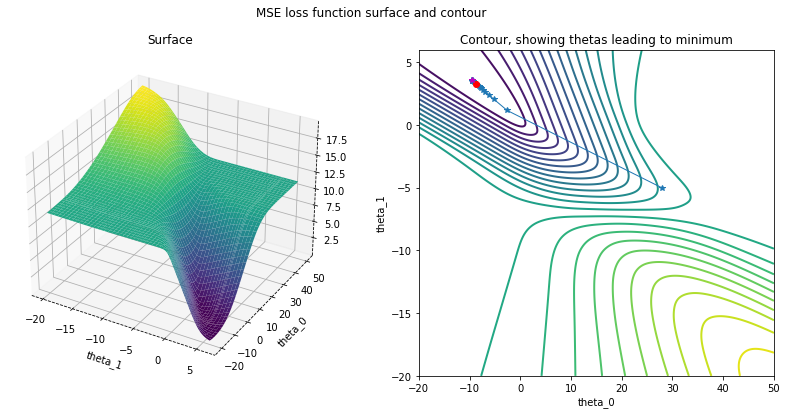

In [277]:
theta_0_lcm = np.array([28.0, -5.0])
iterations = 100000
xmin, xmax = -20, 50
ymin, ymax = -20, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_ce2,'CE')

theta_0_lcm  [40. -7.]
first theta in record should be close to initial theta
first theta for this run  [39.95462592 -7.02118344]
optimal theta lr = 0.1 [-9.46899983  3.54876378]
loss lr=0.1  0.11228072692163343
optimal theta lr =1.0  [-9.46900887  3.54876697]
loss lr= 1.0  0.1122807269215755


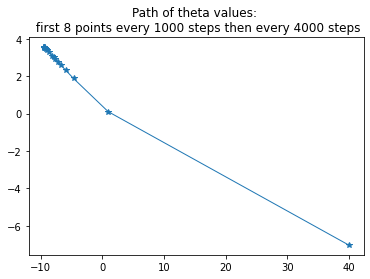

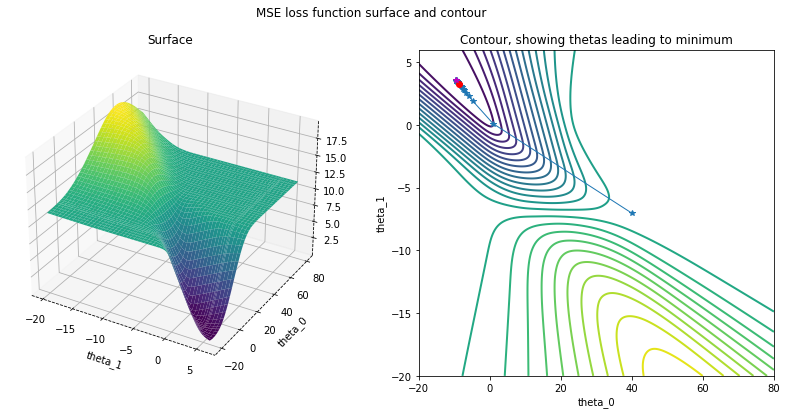

In [278]:
theta_0_lcm = np.array([40.0, -7.0])
iterations = 100000
xmin, xmax = -20, 80
ymin, ymax = -20, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_ce2,'CE')

theta_0_lcm  [30.   2.5]
first theta in record should be close to initial theta
first theta for this run  [29.95033333  2.45259858]
optimal theta lr = 0.1 [-9.46900015  3.54876389]
loss lr=0.1  0.11228072692162942
optimal theta lr =1.0  [-9.46900887  3.54876697]
loss lr= 1.0  0.1122807269215755


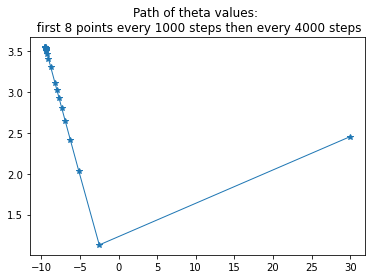

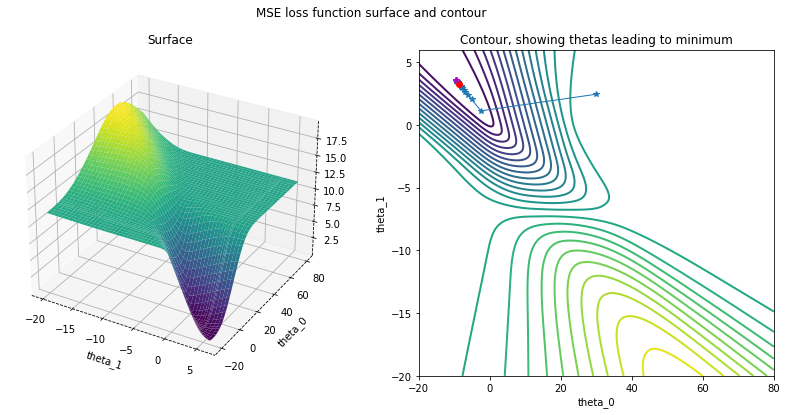

In [279]:
theta_0_lcm = np.array([30.0, 2.5])
iterations = 100000
xmin, xmax = -20, 80
ymin, ymax = -20, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_ce2,'CE')

theta_0_lcm  [60. -1.]
first theta in record should be close to initial theta
first theta for this run  [59.95033333 -1.04740142]
optimal theta lr = 0.1 [-9.46899929  3.54876359]
loss lr=0.1  0.11228072692164058
optimal theta lr =1.0  [-9.46900887  3.54876697]
loss lr= 1.0  0.1122807269215755


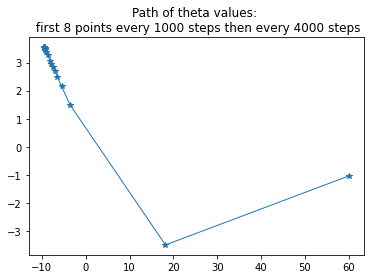

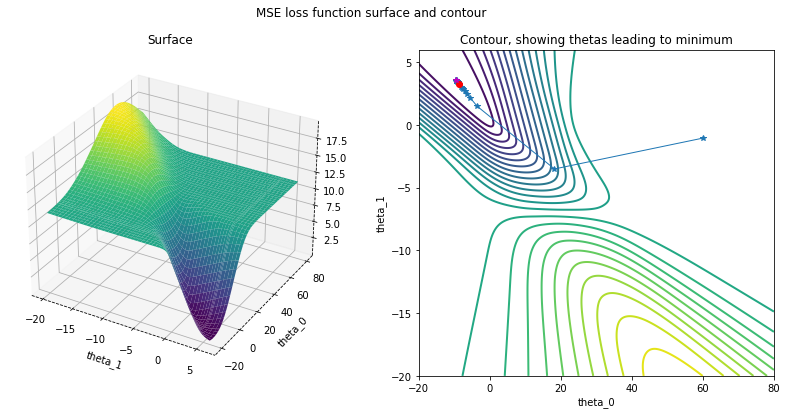

In [280]:
theta_0_lcm = np.array([60.0, -1.0])
iterations = 100000
xmin, xmax = -20, 80
ymin, ymax = -20, 6
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_ce2,'CE')

theta_0_lcm  [-20. -10.]
first theta in record should be close to initial theta
first theta for this run  [-19.94971606  -9.78446091]
optimal theta lr = 0.1 [-9.46908056  3.54879227]
loss lr=0.1  0.11228072692524123
optimal theta lr =1.0  [-9.46900887  3.54876697]
loss lr= 1.0  0.1122807269215755


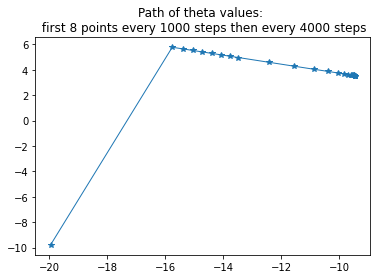

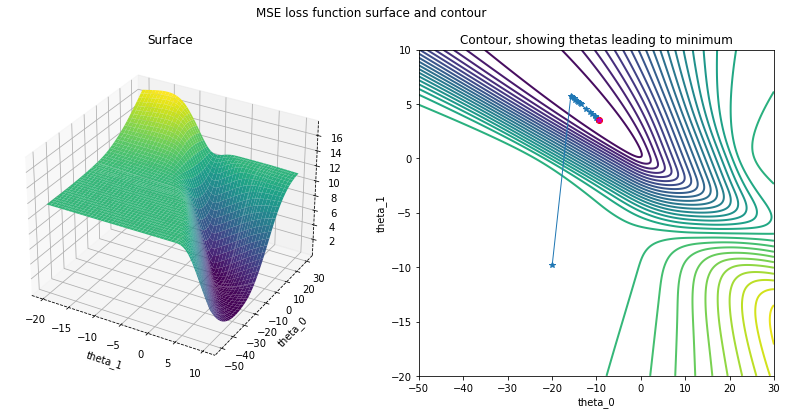

In [282]:
theta_0_lcm = np.array([-20, -10.0])
iterations = 100000
xmin, xmax = -50, 30
ymin, ymax = -20, 10
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_ce2,'CE')

theta_0_lcm  [-40. -10.]
first theta in record should be close to initial theta
first theta for this run  [-39.94966667  -9.78454698]
optimal theta lr = 0.1 [-9.48048245  3.55281513]
loss lr=0.1  0.11228082062803926
optimal theta lr =1.0  [-9.46900887  3.54876697]
loss lr= 1.0  0.1122807269215755


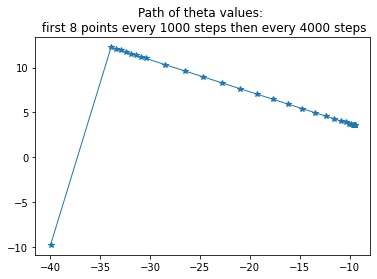

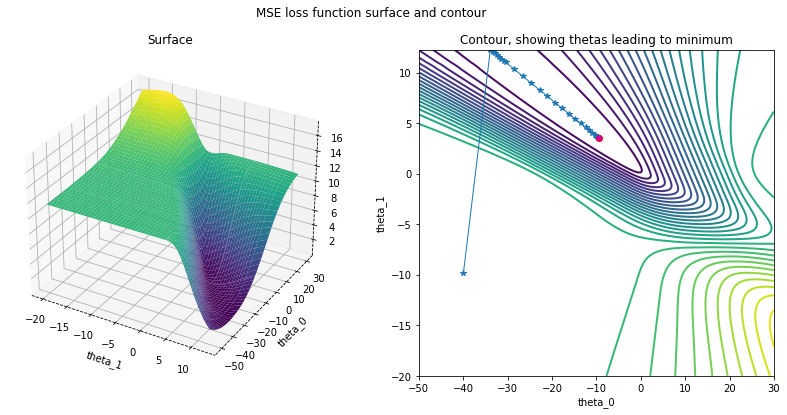

In [283]:
theta_0_lcm = np.array([-40, -10.0])
iterations = 100000
xmin, xmax = -50, 30
ymin, ymax = -20, 10
utils.local_min_contour_plot(X_train_o, y_train, theta_0_lcm, iterations, xmin, xmax, ymin, ymax, theta_ce2,'CE')

## Conclusion:
All the examples above show that the wings of the cross entropy loss function are not leveled and the gradient algorithm with the initial values starting there converge to the global minimum. 

This however is not the case for the mean squared error loss function. We have shown examples where the gradient descent gets stuck in one of the wings.